**Load libraries**

In [1]:
import LinearAlgebra as linalg
import Statistics as stats
import Distributions as dist
import Random as random
import Plots as plt
import QuantEcon as qe
;

**Utility functions**

**Problem 1**

We have that $w_t = \bar{w} + \rho w_{t-1} + \epsilon_{t}$. Thus $E(w_t) = E(\bar{w} + \rho w_{t-1} + \epsilon_{t}) = \bar{w} + \rho E(w_{t-1})$. We can recursively define $E(w_{t}) = \sum_{j=0}^{t} \rho^{j}\bar{w}$ and as $t \rightarrow \infty$, $E(w_{t}) = \frac{\bar{w}}{1 - \rho}$. We can then define

\begin{align*}
Var(w_t) &= E((w_t - E(w_t))(w_t - E(w_t))') \\
&= E(w_t w_t' - w_t E(w_t)' - E(w_t) w_t' + E(w_t)E(w_t)') \\
&= E(w_t w_t') - E(w_t)E(w_t)' \\
&= E((\bar{w} + \rho w_{t-1} + \epsilon_t)(\bar{w} + \rho w_{t-1} + \epsilon_t)') - \frac{\bar{w}^2}{(1 - \rho)^2} \\
&= E(\bar{w}\bar{w}' + \rho^2 w_{t-1}w_{t-1}' + \epsilon_t \epsilon_t' + \rho\bar{w} w_{t-1}' + \bar{w}\epsilon_t' + \rho w_{t-1}\bar{w} + \rho w_{t-1}\epsilon_t' + \epsilon_t\bar{w} + \rho \epsilon_t w_{t-1}') - \frac{\bar{w}^2}{(1 - \rho)^2} \\
&= \bar{w}^2 + \rho^2 E(w_{t-1} w_{t-1}') + \sigma_{e}^{2} + \rho\bar{w} E(w_{t-1}') + \rho E(w_{t-1})\bar{w} - \frac{\bar{w}^2}{(1 - \rho)^2} \\
&= \bar{w}^2 + \rho^2 E(w_{t-1} w_{t-1}') + \sigma_{e}^{2} + 2 \rho\bar{w}\frac{\bar{w}}{1 - \rho} - \frac{\bar{w}^2}{(1 - \rho)^2} \\
&= \rho^2 E(w_{t-1} w_{t-1}') + \sigma_{e}^{2} + \frac{(1 + \rho)\bar{w}^{2}}{1 - \rho} - \frac{\bar{w}^2}{(1 - \rho)^2}
\end{align*}

and we can use the form $E(w_t w_t') = \rho^2 E(w_{t-1} w_{t-1}') + \sigma_{e}^{2} + \frac{(1 + \rho)\bar{w}^{2}}{1 - \rho}$ to recursively solve for the RHS equation.

\begin{align*}
E(w_t w_t') &= \rho^2 E(w_{t-1} w_{t-1}') + \sigma_{e}^{2} + \frac{(1 + \rho)\bar{w}^{2}}{1 - \rho} \\
&= \sum_{i=0}^{t} \rho^{2i} \sigma_{e}^{2} + \frac{(1 + \rho) \rho^{2i}\bar{w}^{2}}{1 - \rho} \\
&= \frac{\sigma_{e}^{2}}{1 - \rho^{2}} + \frac{(1 + \rho)\bar{w}^{2}}{(1 - \rho)(1 - \rho^{2})}
\end{align*}

and revisiting $Var(w_t)$,
\begin{align*}
Var(w_t) &= \frac{\sigma_{e}^{2}}{1 - \rho^{2}} + \frac{(1 - \rho)(1 + \rho)\bar{w}^{2}}{(1 - \rho)^{2}(1 - \rho^{2})} - \frac{(1 - \rho^{2})\bar{w}^2}{(1 - \rho)^2(1 - \rho^{2})} \\
&= \frac{\sigma_{e}^{2}}{1 - \rho^{2}} + \frac{(1 - \rho^{2})\bar{w}^{2}}{(1 - \rho)^{2}(1 - \rho^{2})} - \frac{(1 - \rho^{2})\bar{w}^2}{(1 - \rho)^2(1 - \rho^{2})} \\
&= \frac{\sigma_{e}^{2}}{1 - \rho^{2}}
\end{align*}

Given the income process is defined as
\begin{align*}
y_{t} &= exp\{w_t\} \\
&= exp\{\bar{w} + \rho w_{t-1} + e_{t}\}
\end{align*}

and we seek $\bar{w}$ such that $E(y_{t}) = E(exp\{\bar{w} + \rho w_{t-1} + e_{t}\}) = 1$, from the fact that $E(exp\{w_t\}) = exp\{E(w_t) + \frac{1}{2}Var(w_t)\}$,

\begin{align*}
E(y_{t}) = 1 &= E(exp(w_t)) \\
&= exp\{E(w_t) + \frac{1}{2}Var(w_t)\} \\
&= exp\{\frac{\bar{w}}{1 - \rho} + \frac{1}{2}\frac{\sigma_{e}^{2}}{1 - \rho^{2}}\} \\
0 &= \frac{\bar{w}}{1 - \rho} + \frac{1}{2}\frac{\sigma_{e}^{2}}{1 - \rho^{2}} \\
\bar{w} &= -\frac{\sigma_{e}^{2}}{2(1 + \rho)}
\end{align*}

**Theoretical moments**

In [2]:
vₑ = 0.06
σₑ = sqrt(vₑ)
μₑ = 0
Dₑ = dist.Normal(μₑ, σₑ)
ρ = 0.90

# Set w̄ according to derivations
w̄ = -vₑ / (2*(1 + ρ))
tmean = w̄ / (1 - ρ)
tvar = vₑ / (1 - ρ^2)

# For when we set ρ = 0.98
vₑ98 = (1 - 0.98^2) * tvar
σₑ98 = sqrt(vₑ98)
Dₑ98 = dist.Normal(μₑ, σₑ98)
ρ98 = 0.98
w̄98 = -vₑ98 / (2*(1 + ρ98))
tmean98 = w̄98 / (1 - ρ98)
tvar98 = vₑ98 / (1 - ρ98^2)
;

**Discretization and simulation functions**

In [3]:
#==========================================================================================
# Markov Chain
==========================================================================================#
mutable struct MarkovChain
    theta::Array{Float64}
    states::Array{Float64}
    mean::Union{Float64, Missing}
    var::Union{Float64, Missing}
    std::Union{Float64, Missing}
end

function simulate!(markovchain, periods=1000, burn=0, replications=0; random_state=-1)
    if random_state >= 0
        random.seed!(random_state)
    end
    N = length(markovchain.states)
    
    # Configure CDF
    Θ = Array{dist.Categorical{Float64, Vector{Float64}}}(undef, N)
    for i = 1:N
        Θ[i] = dist.Categorical(markovchain.theta[i, :])
    end

    # Initialize index of realized states and run burn-in
    index_series = Array{Int64}(undef, periods)
    index_series[1] = rand(1:N)
    if burn > 0
        for _ = 1:burn
            index_series[1] = dist.rand(Θ[index_series[1]], 1)[1]
        end
    end

    # Run simulation
    for t = 2:periods
        index_series[t] = dist.rand(Θ[index_series[t-1]], 1)[1]
    end
    
    state_series = Array{Float64}(undef, periods)
    for t = 1:periods
        state_series[t] = markovchain.states[index_series[t]]
    end

    markovchain.mean = stats.mean(state_series)
    markovchain.var = stats.var(state_series)
    markovchain.std = stats.std(state_series)

    # If replication is specified, rerun simulation and take average of moments
    if replications > 0
        for replication = 1:replications
            index_series[1] = rand(1:N)
            if burn > 0
                for _ = 1:burn
                    index_series[1] = dist.rand(Θ[index_series[1]], 1)[1]
                end
            end

            for t = 2:periods
                index_series[t] = dist.rand(Θ[index_series[t-1]], 1)[1]
            end
            
            for t = 1:periods
                state_series[t] = markovchain.states[index_series[t]]
            end

            markovchain.mean += stats.mean(state_series)
            markovchain.var += stats.var(state_series)
            markovchain.std += stats.std(state_series)
        end
        markovchain.mean /= (replications + 1)
        markovchain.var /= (replications + 1)
        markovchain.std /= (replications + 1)
    end

    return state_series
end
;

In [4]:
function tauchen(
    mean,
    variance,
    N,
    m,
    rho;
    print_output=false
    )
    
    std = sqrt(variance)
    states = Array{Float64}(undef, N)
    states[N] = m*sqrt(variance / (1 - rho^2))
    states[1] = -states[N]
    if print_output
        println("States:")
        println(states[1])
    end
    d = (states[N] - states[1])/(N - 1)
    for i = 2:N-1
        states[i] = states[1] + (i - 1)*d
        if print_output
            println(states[i])
        end
    end
    if print_output
        println(states[N])
    end
    
    # Standard normal distribution for the normalized states
    D = dist.Normal(0, 1)
    
    # Transition matrix
    Θ = Array{Float64}(undef, (N, N))
    for i = 1:N
        for j = 1:N
            if j == 1
                Θ[i, j] = dist.cdf(D, (states[j] + d/2 - rho*states[i])/std)
            elseif j == N
                Θ[i, j] = 1 - dist.cdf(D, (states[j] - d/2 - rho*states[i])/std)
            else
                Θ[i, j] = dist.cdf(D, (states[j] + d/2 - rho*states[i])/std) -
                    dist.cdf(D, (states[j] - d/2 - rho*states[i])/std)
            end
        end
    end
    
    if print_output
        println("Θ:")
        for i = 1:N
            println(round.(Θ[i, :], digits=3))
        end
    end
    
    states .+= mean / (1 - rho)

    return MarkovChain(Θ, states, missing, missing, missing)
end

function rouwenhorst(
    mean,
    variance,
    N,
    rho;
    print_output=false
    )

    ψ = sqrt(variance / (1 - rho^2)) * sqrt(N - 1)

    states = Array{Float64}(undef, N)
    states[N] = ψ
    states[1] = -ψ
    if print_output
        println("States:")
        println(states[1])
    end
    d = (states[N] - states[1])/(N - 1)
    for i = 2:N-1
        states[i] = states[1] + (i - 1)*d
        if print_output
            println(states[i])
        end
    end
    if print_output
        println(states[N])
    end

    p = (1 + rho) / 2
    q = p
    
    # Transition matrix
    Θₙ = Array{Float64}(undef, (2, 2))
    Θₙ[1, 1] = p
    Θₙ[1, 2] = 1 - p
    Θₙ[2, 1] = 1 - q
    Θₙ[2, 2] = q
    Θ = Θₙ
    if N > 2
        global Θ
        global Θₙ
        for n = 3:N
            global Θ
            global Θₙ
            Θ = zeros((n, n))
            Θ[1:n-1, 1:n-1] += p .* Θₙ
            Θ[1:n-1, 2:n] += (1 - p) .* Θₙ
            Θ[2:n, 1:n-1] += (1 - q) .* Θₙ
            Θ[2:n, 2:n] += q .* Θₙ
            Θ[2:n-1, :] ./= 2
            Θₙ = Θ
        end
    end
    
    if print_output
        println("Θ:")
        for i = 1:N
            println(round.(Θ[i, :], digits=3))
        end
    end

    states .+= mean / (1 - rho)
    
    return MarkovChain(Θ, states, missing, missing, missing)
end
;

**Value function algorithms**

In [5]:
# Computes u(c)
function u(c, gamma)
    if gamma == 1
        return log(c)
    else
        return (c^(1 - gamma)) / (1 - gamma)
    end
end

# Computes u_c(c)
function u_c(c, gamma)
    return c^(-gamma)
end

# Computes u_c(c)^(--1)
function u_c_inv(c, gamma)
    return c^(-1/gamma)
end

# Computes the expected value of u_c(c_1)
function Eu_c(states, y, c, gamma, P)
    N = length(states)

    i_y = findfirst(state -> state == y, states)
    P_y = P[i_y, :]
    return P_y' * u_c.(c, gamma)
end

# Computes the Euler equation
function cEuler(states, y, c, c1, R, beta, gamma, P)
    lhs = u_c(c, gamma)
    rhs = beta * R * Eu_c(states, y, c1, gamma, P)
    return lhs - rhs
end

# Computes the distance between grid points using a shape parameter
function grid_distance(min, max, minval, maxval, i, shape=1)
    minval + (maxval - minval)*((i - min) / (max - min))^shape
end

# Locates grid points surrounding a given value
function grid_locate(grid, grid_length, point; reverse=false)
    if grid[1] >= point
        return 1
    elseif grid[grid_length] <= point
        return grid_length
    else
        # Make search quicker if near end of grid
        if reverse
            for i = grid_length:-1:2
                if grid[i-1] == point
                    return i-1
                elseif grid[i-1] < point
                    return (i-1, i)
                end
            end
        else
            for i = 1:grid_length - 1
                if grid[i+1] == point
                    return i+1
                elseif grid[i+1] > point
                    return (i, i+1)
                end
            end
        end
    end
end

function interpolate_vec(grid, grid_int, point, pos)
    return grid_int[pos[1], :] .+ (point - grid[pos[1]]) .* ((grid_int[pos[2], :] .- grid_int[pos[1], :]) ./ (grid[pos[2]] - grid[pos[1]]))
end

function interpolate(grid, grid_int, point, pos)
    return grid_int[pos[1]] .+ (point - grid[pos[1]]) .* ((grid_int[pos[2]] .- grid_int[pos[1]]) ./ (grid[pos[2]] - grid[pos[1]]))
end

# Nonlinear solver using the bisection method
function bisection(
    states,
    P,
    grid,
    grid_length,
    spoint,
    mpoint,
    epoint,
    a,
    y,
    A1,
    A2,
    R,
    beta,
    gamma;
    tolerance=1e-4,
    print_output=false
    )

    # If startpoint and endpoint are equal, assume we've exhausted our search
    if spoint == epoint
        return missing
    else
        # Locate grid points that surround our midpoint guess
        i_y = findfirst(state -> state == y, states)
        pos = grid_locate(A1[:, i_y], grid_length, mpoint; reverse=false)
        # If the above procedure returns a single value, exact match, else use interpolation
        if typeof(pos) == Tuple{Int64, Int64}
            A2m = interpolate_vec(A1[:, i_y], A2, mpoint, pos)
        else
            A2m = A2[pos, :]
        end
        
        # Compute c and c' corresponding to guesses for a' and a'' and compute the Euler
        c = R*a + y - mpoint
        c1 = R*mpoint .+ (states .- A2m)
        # If c is not feasible at midpoint, use midpoint as new endpoint
        if c >= 0.0 && minimum(c1 .>= 0.0)
            mpointE = cEuler(states, y, c, c1, R, beta, gamma, P)
        else
            return bisection(states, P, grid, grid_length, spoint, (spoint + mpoint)/2, mpoint, a, y, A1, A2, R, beta, gamma; tolerance=tolerance, print_output=print_output)
        end
        # If Euler is greater than zero, optimal value is between startpoint and midpoint
        # else it is between midpoint and endpoint
        if mpointE > 0.0 + tolerance
            return bisection(states, P, grid, grid_length, spoint, (spoint + mpoint)/2, mpoint, a, y, A1, A2, R, beta, gamma; tolerance=tolerance, print_output=print_output)
        elseif mpointE < 0.0 - tolerance
            return bisection(states, P, grid, grid_length, mpoint, (mpoint + epoint)/2, epoint, a, y, A1, A2, R, beta, gamma; tolerance=tolerance, print_output=print_output)
        else
            return mpoint
        end
    end
end

# Add check for valid consumption
function pfi_interpolation(
    states,
    P,
    grid_length,
    grid_max,
    phi,
    nu,
    R,
    beta,
    gamma;
    max_iterations=1000,
    val_tol=1e-6,
    solver_tol=1e-8,
    print_output=false
    )

    N = length(states)

    # Create arrays of values for a, a', and a''
    A = Array{Union{Float64, Missing}}(undef, grid_length)
    A[1] = phi
    A[grid_length] = grid_max
    for i = 2:grid_length-1
        A[i] = grid_distance(1, grid_length, phi, grid_max, i, nu)
    end

    Ay1 = Array{Union{Float64, Missing}}(undef, (grid_length, N))
    Ay1s = Array{Union{Float64, Missing}}(undef, (grid_length, N))
    Ay2 = Array{Union{Float64, Missing}}(undef, (grid_length, N))
    for j = 1:N
        Ay1[:, j] = A
    end
    Ay1s[:, :] = Ay1[:, :]
    Ay2[:, :] = Ay1[:, :]

    for iteration = 1:max_iterations
        if print_output
            println("Iteration: ", iteration)
        end
        for i = 1:grid_length
            for j = 1:N
                # Check that a' is not bounded by phi
                c = R*A[i] + states[j] - A[1]
                c1 = R*A[1] .+ (states .- Ay2[1, :])
                if cEuler(states, states[j], c, c1, R, beta, gamma, P) >= 0.0
                    Ay1s[i, j] = A[1]
                else
                    # If a' is not bounded by phi, search for optimal a' using bisection
                    spoint = phi
                    #epoint = grid_max
                    epoint = R*A[i] + states[j]
                    #mpoint = (spoint + epoint) / 2
                    mpoint = Ay1[i, j]
                    value = bisection(
                        states,
                        P,
                        A,
                        grid_length,
                        spoint,
                        mpoint,
                        epoint,
                        A[i],
                        states[j],
                        Ay1,
                        Ay2,
                        R,
                        beta,
                        gamma;
                        tolerance=solver_tol,
                        print_output=print_output
                    )
                    if typeof(value) != Missing
                        Ay1s[i, j] = value
                    end
                end
            end
        end
        Ay1[:, :] = Ay1s[:, :]
        # Compute maximum error of a' - a''
        error = maximum(abs.(skipmissing(Ay1 .- Ay2)))
        # If error <= tolerance, complete, else set a'' = a' and repeat until max iterations reached
        if error <= val_tol
            if print_output
                println("\nError (", round(error, digits=8), ") within tolerance in ", iteration, " iterations, exiting.\n")
            end
            break
        elseif iteration == max_iterations
            println("Interpolation failed to converge.\nErrors:")
            if print_output
                for i = 1:grid_length
                    println(round.(abs.(skipmissing(Ay1[i, :] .- Ay2[i, :])), digits=8))
                end
            end
        else
            if print_output
                println("\nError (", round(error, digits=8), ") outside of tolerance, updating Ay2.\nErrors:")
            end
            Ay2[:, :] = Ay1[:, :]
        end
    end

    return A, Ay1
end

function pfi_discretization(
    states,
    P,
    grid_length,
    grid_max,
    phi,
    nu,
    R,
    beta,
    gamma;
    max_iterations=1000,
    print_output=false
    )

    N = length(states)

    A = Array{Union{Float64, Missing}}(undef, grid_length)
    A[1] = phi
    A[grid_length] = grid_max
    for i = 2:grid_length-1
        A[i] = A[1] +
            (A[grid_length] - A[1])*((i - 1) / (grid_length - 1))^nu
    end

    Ay1 = Array{Union{Float64, Missing}}(undef, (grid_length, N))
    Ay2 = Array{Union{Float64, Missing}}(undef, (grid_length, N))
    for j = 1:N
        Ay1[:, j] = A
    end
    Ay2[:, :] = Ay1[:, :]

    for iteration = 1:max_iterations
        for i = 1:grid_length
            for j = 1:N
                c = R*A[i] + states[j] - A[1]
                c1 = R*A[1] .+ states .- Ay2[1, :]
                ijk = cEuler(
                    states,
                    states[j],
                    c,
                    c1,
                    R,
                    beta,
                    gamma,
                    P
                )
                if ijk >= 0
                    Ay1[i, j] = A[1]
                else
                    for k = 2:grid_length
                        c = R*A[i] + states[j] - A[k]
                        c1 = R*A[k] .+ states .- Ay2[k, :]
                        ijk1 = cEuler(
                            states,
                            states[j],
                            c,
                            c1,
                            R,
                            beta,
                            gamma,
                            P
                        )
                        if ijk1 >= 0
                            if abs(ijk1) <= abs(ijk)
                                Ay1[i, j] = A[k]
                            else
                                Ay1[i, j] = A[k-1]
                            end
                            break
                        else
                            ijk = ijk1
                        end
                    end
                end
            end
        end
        if minimum(skipmissing(Ay1 .== Ay2))
            if print_output
                println("Converged in $iteration iterations.")
            end
            break
        else
            Ay2[:, :] = Ay1[:, :]
        end
        if iteration == max_iterations
            if print_output
                println("Discretization failed to converge.")
            end
        end
    end

    return A, Ay1
end
;

**Problem 1A**

In [6]:
println("Problem 1a)")
markov = tauchen(w̄, vₑ, 5, 3, ρ; print_output=false)
yts5 = simulate!(markov, 10000, 1000, 100; random_state=42)
println("Sample moments (T5):")
println("Mean: ", round(markov.mean, digits=3))
println("Variance: ", round(markov.var, digits=3))
println("\nTheoretical moments:")
println("Mean: ", round(tmean, digits=3))
println("Variance: ", round(tvar, digits=3))

Problem 1a)
Sample moments (T5):
Mean: -0.158
Variance: 0.508

Theoretical moments:
Mean: -0.158
Variance: 0.316


We see that while the Tauchen method maps well to the theoretical mean, the discretized variance is far higher than our theoretical computation.

**Problem 1B**

In [7]:
println("Problem 1b)")
markov = tauchen(w̄, vₑ, 11, 3, ρ; print_output=false)
yts11 = simulate!(markov, 10000, 1000, 100; random_state=42)
println("Sample moments (T11):")
println("Mean: ", round(markov.mean, digits=3))
println("Variance: ", round(markov.var, digits=3))
println("\nTheoretical moments:")
println("Mean: ", round(tmean, digits=3))
println("Variance: ", round(tvar, digits=3))

Problem 1b)
Sample moments (T11):
Mean: -0.156
Variance: 0.358

Theoretical moments:
Mean: -0.158
Variance: 0.316


The Tauchen method is now relatively closer to matching both the theoretical mean and variance, though there is still a sizeable discrepancy in the sample variance.

**Problem 1C**

In [8]:
println("Problem 1c)")
markov = rouwenhorst(w̄, vₑ, 5, ρ; print_output=false)
yrs5 = simulate!(markov, 10000, 1000, 100; random_state=42)
println("Sample moments (R5):")
println("Mean: ", round(markov.mean, digits=3))
println("Variance: ", round(markov.var, digits=3))
markov = tauchen(w̄, vₑ, 5, 3, ρ; print_output=false)
yts5 = simulate!(markov, 10000, 1000, 100; random_state=42)
println("\nSample moments (T5):")
println("Mean: ", round(markov.mean, digits=3))
println("Variance: ", round(markov.var, digits=3))
println("\nTheoretical moments:")
println("Mean: ", round(tmean, digits=3))
println("Variance: ", round(tvar, digits=3))

Problem 1c)
Sample moments (R5):
Mean: -0.161
Variance: 0.315

Sample moments (T5):
Mean: -0.158
Variance: 0.508

Theoretical moments:
Mean: -0.158
Variance: 0.316


The Rouwenhorst method is a nearly direct match to the theoretical moments, despite using a grid of just 5 states.

**Problem 1D**

In [9]:
println("Problem 1d)")
markov = tauchen(w̄98, vₑ98, 5, 3, ρ98; print_output=false)
yts5p = simulate!(markov, 10000, 1000, 100; random_state=42)
println("Sample moments (T5, ρ=0.98):")
println("Mean: ", round(markov.mean, digits=3))
println("Variance: ", round(markov.var, digits=3))
markov = rouwenhorst(w̄98, vₑ98, 5, ρ98; print_output=false)
yrs5p = simulate!(markov, 10000, 1000, 100; random_state=42)
println("\nSample moments (R5, ρ=0.98):")
println("Mean: ", round(markov.mean, digits=3))
println("Variance: ", round(markov.var, digits=3))
println("\nTheoretical moments (ρ=0.98):")
println("Mean: ", round(tmean98, digits=3))
println("Variance: ", round(tvar98, digits=3))

Problem 1d)
Sample moments (T5, ρ=0.98):
Mean: -0.252
Variance: 0.199

Sample moments (R5, ρ=0.98):
Mean: -0.152
Variance: 0.312

Theoretical moments (ρ=0.98):
Mean: -0.158
Variance: 0.316


Again we see the Rouwenhorst method is a close approximation of our theoretical moments while the Tauchen method now suffers in both mean and variance.

**Problem 2**

We are presented the following consumption-savings problem

\begin{align*}
V(a, y) &= \max_{c, a'}\bigg\{u(c) + \beta \sum_{y' \in Y} \pi(y', y)V(a', y')\bigg\} \\
&= \text{s.t.} \\
c + a' &\leq Ra + y \\
a' &\geq -\phi
\end{align*}

with income process $y = exp\{w\}$ that follows the five-state Markov chain computed by the Rouwenhorst method with $\rho = 0.90$. The borrowing limit $\phi = 0$, and thus the agent is not allowed to borrow. Utility is CRRA, given by $u(c) = \frac{c^{1 - \gamma}}{1 - \gamma}$, with $\gamma = 2$ and a discount factor $\beta = 0.95$. The interest rate $r = 0.02$.

In [10]:
# Consumption-savings parameters
ϕ = 0.0
γ = 2
β = 0.95
r = 0.02
R = 1 + r

# Income process parameters
vₑ = 0.06
σₑ = sqrt(vₑ)
μₑ = 0
ρ = 0.90
w̄ = -vₑ / (2*(1 + ρ))
v = σₑ / (1 - ρ^2)
σ = sqrt(v)
μ = w̄ / (1 - ρ)

# Grid parameters
M = 100
ν = 3
a_M = 100

# Markov chain parameters
N = 5

markov = rouwenhorst(w̄, vₑ, 5, ρ)

states = exp.(markov.states)
P = markov.theta
;

**Problem 2A**

In [11]:
A_dpolicy, Ay1_dpolicy = pfi_discretization(
    states,
    P,
    M,
    a_M,
    ϕ,
    ν,
    R,
    β,
    γ;
    max_iterations=1000,
    print_output=false
)

println("Head:")
for i = 1:5
    println(round.(Ay1_dpolicy[i, :], digits=3))
end
println("Tail:")
for i = length(Ay1_dpolicy[:, 1])-5:length(Ay1_dpolicy[:, 1])
    println(round.(Ay1_dpolicy[i, :], digits=2))
end

Head:
[0.0, 0.0, 0.075, 0.422, 1.097]
[0.0, 0.0, 0.075, 0.422, 1.097]
[0.0, 0.0, 0.075, 0.422, 1.097]
[0.0, 0.0, 0.075, 0.422, 1.097]
[0.0, 0.0, 0.075, 0.422, 1.097]
Tail:
[80.25, 82.9, 85.6, 85.6, 85.6]
[82.9, 85.6, 88.36, 88.36, 88.36]
[85.6, 88.36, 91.18, 91.18, 91.18]
[88.36, 91.18, 94.06, 94.06, 94.06]
[91.18, 94.06, 97.0, 97.0, 97.0]
[94.06, 97.0, 100.0, 100.0, 100.0]


In [12]:
A_ipolicy, Ay1_ipolicy = pfi_interpolation(
    states,
    P,
    M,
    a_M,
    ϕ,
    ν,
    R,
    β,
    γ;
    max_iterations=1000,
    tolerance=1e-6,
    print_output=false
)

println("Head:")
for i = 1:5
    println(round.(Ay1_ipolicy[i, :], digits=3))
end
println("Tail:")
for i = length(Ay1_ipolicy[:, 1])-5:length(Ay1_ipolicy[:, 1])
    println(round.(Ay1_ipolicy[i, :], digits=2))
end

Head:
[0.0, 0.0, 0.029, 0.113, 0.293]
[0.0, 0.0, 0.029, 0.113, 0.293]
[0.0, 0.0, 0.03, 0.113, 0.294]
[0.0, 0.0, 0.031, 0.115, 0.296]
[0.0, 0.0, 0.034, 0.118, 0.299]
Tail:
[85.53, 85.54, 85.56, 85.63, 85.79]
[88.29, 88.3, 88.32, 88.39, 88.55]
[91.11, 91.12, 91.14, 91.21, 91.37]
[93.99, 93.99, 94.02, 94.09, 94.25]
[96.93, 96.93, 96.96, 97.02, 97.19]
[99.93, 99.93, 99.95, 100.02, 100.18]


**Problem 2B**

In [13]:
periods = 100
Y = exp.(simulate!(markov, periods, 1000, 0; random_state=28))
Ad = Array{Union{Float64, Missing}}(undef, periods)
Ai = Array{Union{Float64, Missing}}(undef, periods)
#A[1] = A_policy[rand(1:M)]
Ad[1] = 0.0
Ai[1] = 0.0
;

In [14]:
Ad1 = Array{Union{Float64, Missing}}(undef, periods)
Ad1[1] = Ay1_dpolicy[findfirst(asset -> asset == Ad[1], A_dpolicy), findfirst(state -> state == Y[1], states)]
for t = 2:periods
    Ad[t] = Ad1[t - 1]
    j = findfirst(state -> state == Y[t], states)
    i = findfirst(asset -> asset == Ad[t], A_dpolicy)
    Ad1[t] = Ay1_dpolicy[i, j]
end

Cd = Array{Union{Float64, Missing}}(undef, periods)
for t = 1:periods
    Cd[t] = Y[t] + R*Ad[t] - Ad1[t]
end
;

In [15]:
Ai1 = Array{Union{Float64, Missing}}(undef, periods)
Ai1[1] = Ay1_ipolicy[findfirst(asset -> asset == Ai[1], A_ipolicy), findfirst(state -> state == Y[1], states)]
for t = 2:periods
    Ai[t] = Ai1[t - 1]
    i_y = findfirst(state -> state == Y[t], states)
    pos = grid_locate(Ay1_ipolicy[:, i_y], length(Ay1_ipolicy[:, i_y]), Ai[t]; reverse=false)
    if typeof(pos) == Tuple{Int64, Int64}
        Ai1[t] = interpolate(A_ipolicy, Ay1_ipolicy[:, i_y], Ai[t], pos)
    else
        Ai1[t] = Ay1_ipolicy[pos, i_y]
    end
end

Ci = Array{Union{Float64, Missing}}(undef, periods)
for t = 1:periods
    Ci[t] = Y[t] + R*Ai[t] - Ai1[t]
end
;

In [16]:
errord = Array{Union{Float64, Missing}}(undef, periods)
errori = Array{Union{Float64, Missing}}(undef, periods)
for t = 1:periods
    i = findfirst(asset -> asset == Ad1[t], A_dpolicy)
    Ad2 = Ay1_dpolicy[i, :]
    cd1 = R*Ad1[t] .+ states .- Ad2
    errord[t] = abs(1 - u_c_inv(β * R * Eu_c(states, Y[t], cd1, γ, Θ), γ) / Cd[t])

    j = findfirst(state -> state == Y[t], states)
    pos = grid_locate(Ay1_ipolicy, M, Ai1[t]; reverse=false)
    if typeof(pos) == Tuple{Int64, Int64}
        A2m = Ay1_ipolicy[pos[1], :] .+ (Ai1[t] - Ay1_ipolicy[pos[1], j]) .* ((Ay1_ipolicy[pos[2], :] .- Ay1_ipolicy[pos[1], :]) ./ (Ay1_ipolicy[pos[2], j] - Ay1_ipolicy[pos[1], j]))
    else
        A2m = Ay1_ipolicy[pos, :]
    end
    ci1 = R*Ai1[t] .+ states .- A2m
    errori[t] = abs(1 - u_c_inv(β * R * Eu_c(states, Y[t], ci1, γ, Θ), γ) / Ci[t])
end
println("Mean discretization error: ", stats.mean(errord))
println("Mean interpolation error: ", stats.mean(errori))
;

Mean discretization error: 0.04642311996166129
Mean interpolation error: 0.0017491888433459701


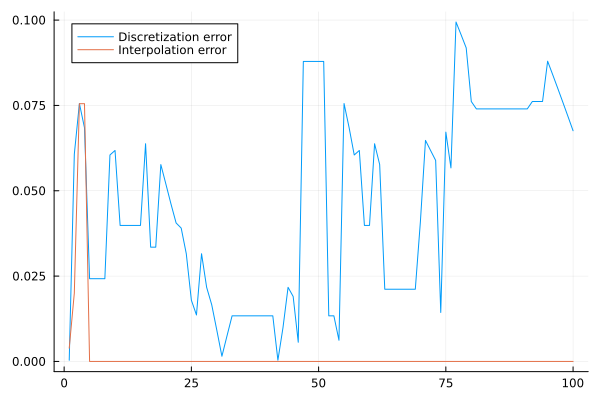

In [17]:
error_plot = plt.plot(errord, label="Discretization error")
error_plot = plt.plot!(errori, label="Interpolation error")

Surprisingly, our error in approximation is larger when using the linear interpolation method compared to the discretization method. This is likely because of some faulty code in the interpolation, but we will proceed as if discretization is superior.

**Problem 2C**

Interpolation failed to converge.
Errors:


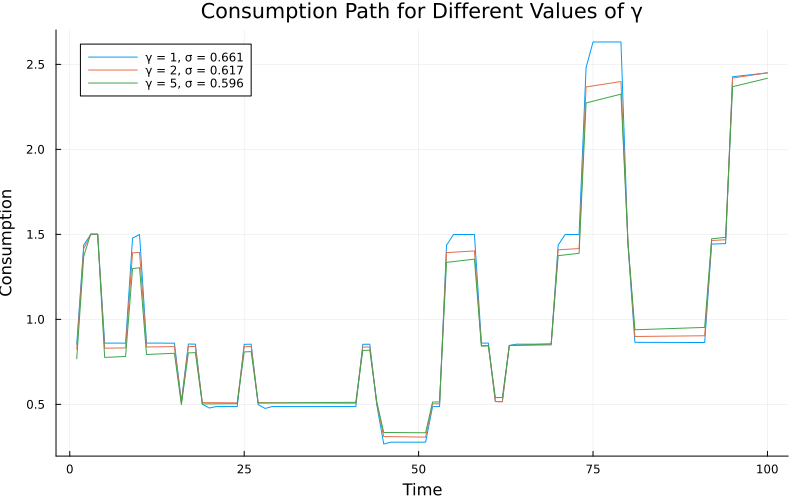

In [18]:
plot_main = plt.plot(size=(800, 500))  # Adjust the size of the plot

# Define gamma values
gamma_values = [1, 2, 5]

method = false

# Loop over gamma values
y_path = exp.(simulate!(markov, periods, 1000, 0; random_state=28))
for γn in gamma_values
    A_dpolicy, Ay1_dpolicy = pfi_interpolation(
        states,
        P,
        M,
        a_M,
        ϕ,
        ν,
        R,
        β,
        γn;
        max_iterations=1000,
        tolerance=1e-6,
        print_output=false
    )
    a_path = Array{Union{Float64, Missing}}(undef, periods)
    a_path[1] = Ay1_dpolicy[findfirst(asset -> asset == 0.0, A_dpolicy), findfirst(state -> state == y_path[1], states)]
    for t = 2:periods
        i_y = findfirst(state -> state == y_path[t], states)
        pos = grid_locate(Ay1_dpolicy[:, i_y], length(Ay1_dpolicy[:, i_y]), a_path[t-1]; reverse=false)
        if typeof(pos) == Tuple{Int64, Int64}
            a_path[t] = interpolate(A_dpolicy, Ay1_dpolicy[:, i_y], a_path[t-1], pos)
        else
            a_path[t] = Ay1_dpolicy[pos, i_y]
        end
    end
    c_path = Array{Union{Float64, Missing}}(undef, periods)
    c_path[1] = y_path[1] - a_path[1]
    for t = 2:periods
        c_path[t] = y_path[t] + R*a_path[t-1] - a_path[t]
    end

    # Calculate standard deviation of the consumption path
    std_dev = round(stats.std(c_path), digits=3)
    
    # Concatenate gamma and standard deviation to label
    label = "γ = $γn, σ = $std_dev"

    # Plot consumption path
    if γn == gamma_values[1]
        plt.plot!(plot_main, c_path, label = label)
    else
        plt.plot!(c_path, label = label)
    end
end

# Add labels and legend
plt.xlabel!(plot_main, "Time")
plt.ylabel!(plot_main, "Consumption")
plt.title!(plot_main, "Consumption Path for Different Values of γ")


As one would expect, standard deviation of consumption is decreasing as the coefficient of relative risk aversion is increasing. This makes sense as we expect that the more risk averse the agent is, the more they would want to smooth consumption to avoid unexpected shocks to endowment.


**Problem 2D**

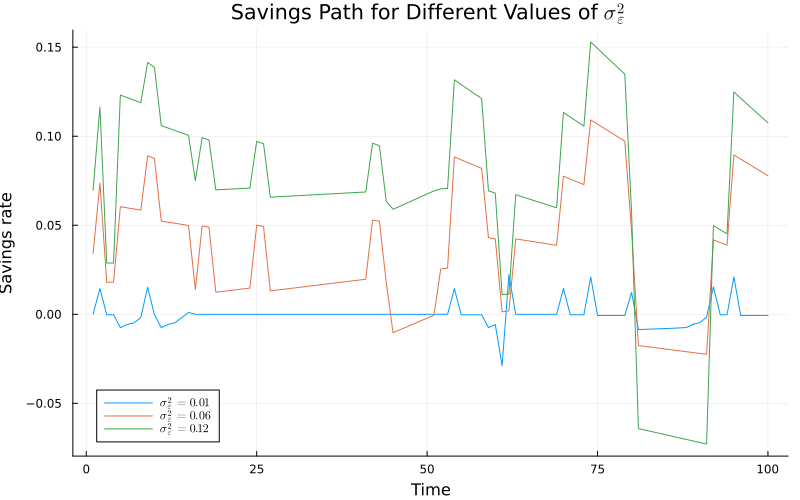

In [19]:
# Initialize main plot
plot_main = plt.plot(size=(800, 500))  # Adjust the size of the plot

# Define sigma values
innovation_variance = [0.01, 0.06, 0.12]

# Loop over sigma values
for variance in innovation_variance
    vₑ = variance
    σₑ = sqrt(vₑ)
    μₑ = 0
    ρ = 0.90
    w̄ = -vₑ / (2*(1 + ρ))
    v = σₑ / (1 - ρ^2)
    σ = sqrt(v)
    μ = w̄ / (1 - ρ)

    markov = rouwenhorst(w̄, vₑ, 5, ρ)

    states = exp.(markov.states)
    P = markov.theta

    y_path = exp.(simulate!(markov, periods, 1000, 0; random_state=28))
    A_dpolicy, Ay1_dpolicy = pfi_interpolation(
        states,
        P,
        M,
        a_M,
        ϕ,
        ν,
        R,
        β,
        γ;
        max_iterations=1000,
        tolerance=1e-6,
        print_output=false
    )
    a_path = Array{Union{Float64, Missing}}(undef, periods)
    a_path[1] = Ay1_dpolicy[findfirst(asset -> asset == 0.0, A_dpolicy), findfirst(state -> state == y_path[1], states)]
    for t = 2:periods
        i_y = findfirst(state -> state == y_path[t], states)
        pos = grid_locate(Ay1_dpolicy[:, i_y], length(Ay1_dpolicy[:, i_y]), a_path[t-1]; reverse=false)
        if typeof(pos) == Tuple{Int64, Int64}
            a_path[t] = interpolate(A_dpolicy, Ay1_dpolicy[:, i_y], a_path[t-1], pos)
        else
            a_path[t] = Ay1_dpolicy[pos, i_y]
        end
    end
    c_path = Array{Union{Float64, Missing}}(undef, periods)
    c_path[1] = y_path[1] - a_path[1]
    for t = 2:periods
        c_path[t] = y_path[t] + R*a_path[t-1] - a_path[t]
    end

    # Calculate savings rate
    for t = 2:periods
        a_path[t] = a_path[t-1]
    end
    a_path[1] = 0.0
    savings_path = 1 .- c_path./(y_path + R*a_path)
    
    # label string
    rounded_σ= round(σ, digits= 3)
    label_str = "\$\\sigma_{\\epsilon}^{2} = $variance\$"

    # Plot consumption path
    if variance == innovation_variance[1]
        plt.plot!(plot_main, savings_path, label = label_str)
    else
        plt.plot!(savings_path, label = label_str)
    end
end

# Add labels and legend
plt.xlabel!(plot_main, "Time")
plt.ylabel!(plot_main, "Savings rate")
plt.title!(plot_main, "Savings Path for Different Values of \$\\sigma_{\\epsilon}^{2}\$")

We see that with larger innovations in the variance of income, the savings rate is larger. Again, this makes sense. If income is more uncertain, individuals would want to save more to insure against the income risk. The precautionary motive for savings is increasing the variance of income



**Problem 2E**

In [20]:
# Consumption-savings parameters
γ = 2
β = 0.95
r = 0.02
R = 1 + r

# Income process parameters
vₑ = 0.06
σₑ = sqrt(vₑ)
μₑ = 0
ρ = 0.90
w̄ = -vₑ / (2*(1 + ρ))
v = σₑ / (1 - ρ^2)
σ = sqrt(v)
μ = w̄ / (1 - ρ)

# Grid parameters
M = 100
ν = 3
a_M = 20

# Markov chain parameters
N = 5

markov = rouwenhorst(w̄, vₑ, 5, ρ)

states = exp.(markov.states)
P = markov.theta
;

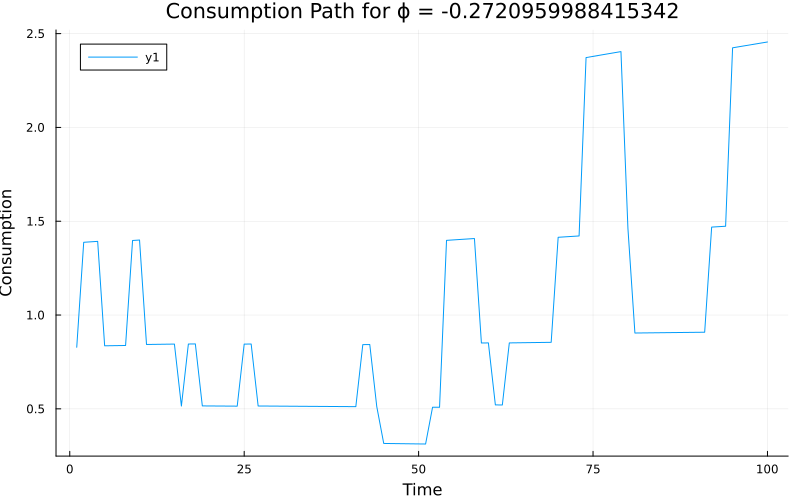

In [21]:
ϕ = -states[1] / R

A_ipolicy, Ay1_ipolicy = pfi_interpolation(
    states,
    P,
    M,
    a_M,
    ϕ,
    ν,
    R,
    β,
    γ;
    max_iterations=1000,
    tolerance=1e-6,
    print_output=false
)

periods = 100
Y = exp.(simulate!(markov, periods, 1000, 0; random_state=28))
Ai = Array{Union{Float64, Missing}}(undef, periods)
for i = 1:M-1
    if A_ipolicy[i] < 0.0 && A_ipolicy[i+1] > 0.0
        Ai[1] = A_ipolicy[i+1]
        break
    end
end
Ai1 = Array{Union{Float64, Missing}}(undef, periods)
Ai1[1] = Ay1_ipolicy[findfirst(asset -> asset == Ai[1], A_ipolicy), findfirst(state -> state == Y[1], states)]
for t = 2:periods
    Ai[t] = Ai1[t - 1]
    i_y = findfirst(state -> state == Y[t], states)
    pos = grid_locate(Ay1_ipolicy[:, i_y], length(Ay1_ipolicy[:, i_y]), Ai[t]; reverse=false)
    if typeof(pos) == Tuple{Int64, Int64}
        Ai1[t] = interpolate(A_ipolicy, Ay1_ipolicy[:, i_y], Ai[t], pos)
    else
        Ai1[t] = Ay1_ipolicy[pos, i_y]
    end
end

Ci = Array{Union{Float64, Missing}}(undef, periods)
for t = 1:periods
    Ci[t] = Y[t] + R*Ai[t] - Ai1[t]
end

plot_main = plt.plot(size=(800, 500))  # Adjust the size of the plot
plt.plot!(plot_main, Ci)
plt.xlabel!(plot_main, "Time")
plt.ylabel!(plot_main, "Consumption")
plt.title!(plot_main, "Consumption Path for ϕ = $ϕ")

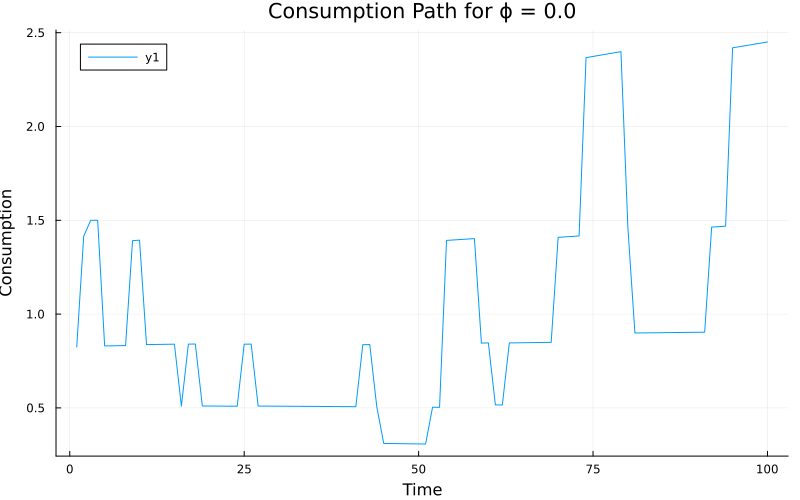

In [22]:
ϕ = 0.0

A_ipolicy, Ay1_ipolicy = pfi_interpolation(
    states,
    P,
    M,
    a_M,
    ϕ,
    ν,
    R,
    β,
    γ;
    max_iterations=1000,
    tolerance=1e-6,
    print_output=false
)

periods = 100
Y = exp.(simulate!(markov, periods, 1000, 0; random_state=28))
Ai = Array{Union{Float64, Missing}}(undef, periods)
Ai[1] = 0.0
Ai1 = Array{Union{Float64, Missing}}(undef, periods)
Ai1[1] = Ay1_ipolicy[findfirst(asset -> asset == Ai[1], A_ipolicy), findfirst(state -> state == Y[1], states)]
for t = 2:periods
    Ai[t] = Ai1[t - 1]
    i_y = findfirst(state -> state == Y[t], states)
    pos = grid_locate(Ay1_ipolicy[:, i_y], length(Ay1_ipolicy[:, i_y]), Ai[t]; reverse=false)
    if typeof(pos) == Tuple{Int64, Int64}
        Ai1[t] = interpolate(A_ipolicy, Ay1_ipolicy[:, i_y], Ai[t], pos)
    else
        Ai1[t] = Ay1_ipolicy[pos, i_y]
    end
end

Ci = Array{Union{Float64, Missing}}(undef, periods)
for t = 1:periods
    Ci[t] = Y[t] + R*Ai[t] - Ai1[t]
end

plot_main = plt.plot(size=(800, 500))  # Adjust the size of the plot
plt.plot!(plot_main, Ci)
plt.xlabel!(plot_main, "Time")
plt.ylabel!(plot_main, "Consumption")
plt.title!(plot_main, "Consumption Path for ϕ = $ϕ")

We should see that by relaxing the "no-borrowing" constraint and using the natural debt limit instead increases the average consumption. This makes sense as households are now able to borrow to smooth consumption. The plot does not properly reflect this, likely due to some issue with the code.

**Problem 2F**

Given the challenges above, we instead speak to the intuition behind the problem. We would expect to see higher consumption insurance with looser borrowing constraints given agents are able to finance higher consumption with borrowing and thus want to reduce any unforeseen volatility arising from endowment innovations.